# **Introduction**

Missing values are a common challenge in machine learning datasets. At first glance, handling them might seem straightforward—dropping rows or columns or imputing missing values using simple techniques like mean, median, or mode. While these approaches can work in some cases, they often fail to capture the nuances of missing data. A deeper understanding of the types of missing data and their implications is crucial for building robust machine learning models.

In general, missing data can be categorized into three types:

1. **Missing Completely At Random (MCAR)**
 * **Definition:**

    Data is considered Missing Completely At Random (MCAR) if the probability of a data point being missing is unrelated to either the observed data or the missing data itself. In other words, there is no discernible pattern or reason behind the missingness.

 * **Example:**

    A survey where a random glitch in the system causes some responses to be lost, regardless of the respondent's answers or characteristics. During data entry, a technician accidentally skips random entries without any bias.

 * **Why & How it Occurs?**
    
    MCAR often occurs due to random, external factors such as:
    - Technical errors in data collection (e.g., random network failures).
    - Random accidents during manual data entry.

 * **How to Solve?**

    If data is MCAR, the missingness is truly random, and analysis is less biased. Common approaches include:
    - **Deletion Methods**: Remove rows or columns with missing data if the proportion of missingness is low.
    - Example: If only 1-2% of data points are missing, deletion might be acceptable.
    - **Imputation Techniques**:
        - Use simple imputation methods like mean, median, or mode.
        - Advanced methods: Predict the missing values using regression or machine learning models trained on the observed data.
    - **Multiple Imputation**: Generate several plausible datasets by imputing missing values multiple times, analyze each dataset, and combine results for robustness.

2. **Missing At Random (MAR)**

 * **Definition**
    
    Data is Missing At Random (MAR) when the probability of missingness depends on the observed data but not on the missing data itself. In simpler terms, the missingness is systematic and can be explained by other variables in the dataset.

 * **Example**
    - In a medical survey, younger participants are less likely to disclose their income. The missingness of income data depends on the age variable, which is observed.
    - Students with lower grades might be less likely to report their attendance, making missing attendance correlated with observed grades.

 * **Why & How it Occurs?**
    
    MAR typically arises due to relationships between observed variables and missingness:
        - Certain subgroups or patterns influence the likelihood of missing data.
        - Respondent behaviors or preferences are influenced by factors measured in the dataset.

 * **How to Solve?**

    Handling MAR requires understanding and leveraging the relationships between variables:
    - **Imputation Techniques**:
        - Use **conditional imputation** based on observed variables. For example, impute income based on age, education, and occupation.
        - **K-Nearest Neighbors (KNN)**: Impute missing values based on the most similar observations in the dataset.
        - **Regression Imputation**: Use regression models to predict missing values based on correlated observed variables.
    - **Multiple Imputation**:
        - Generate multiple datasets using MAR assumptions, then analyze and pool results.
    - **Inverse Probability Weighting**: Adjust the weights of observations during analysis to account for the likelihood of missingness.

3. **Missing Not At Random (MNAR)**

 * **Definition**

    Data is Missing Not At Random (MNAR) when the missingness depends on the value of the missing data itself. This introduces bias because the missing values are systematically different from the observed values.

 * **Example**

    - High earners may be less likely to disclose their income, leading to an underrepresentation of high-income data.
    - Patients experiencing severe side effects might drop out of a clinical trial, causing the dataset to miss critical information.

 * **Why & How it Occurs?**

    MNAR arises due to:
        - Self-selection bias: Respondents intentionally omit sensitive or stigmatized information.
        - Behavioral biases or decisions influenced by the missing data.

 * **How to Solve?**

    MNAR is the most challenging type to handle because the missingness cannot be explained by observed data alone:
    - **Model-Based Approaches**:
        - Use advanced statistical models to estimate and handle MNAR patterns. For example, mixed models or joint modeling approaches.
    - **Sensitivity Analysis**:
        - Test various scenarios and assumptions about the missing data to understand its impact on results.
    - **Data Collection Improvements**:
        - Attempt to reduce MNAR by redesigning data collection processes, such as anonymizing surveys or incentivizing responses.
    - **Pattern Analysis**:
        - Investigate patterns in missingness to hypothesize and test potential reasons for MNAR.

**Key Takeaways**

1. The choice of method to handle missing data depends on the type of missingness.
2. Simple imputation methods (mean, median) might suffice for MCAR data but are less suitable for MAR or MNAR scenarios.
3. Advanced techniques like regression imputation, multiple imputation, and sensitivity analysis provide better results for MAR and MNAR.
4. Understanding why data is missing is as important as addressing the missingness.

By carefully analyzing the nature of missing data and selecting appropriate methods, you can ensure that your machine learning models are more accurate, reliable, and robust.

# **Set Up**

In [1]:
!pip install -q pykalman pyampute

# Data Imports
import os
import kagglehub
import numpy as np
import pandas as pd

# MCAR Test
from pyampute.exploration.mcar_statistical_tests import MCARTest

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Imputation Techniques
from sklearn.impute import KNNImputer

from sklearn.linear_model import LinearRegression

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

!pip install fancyimpute -q
from fancyimpute import IterativeImputer as FIterativeImputer

!pip install miceforest -q
import miceforest as mf

# Time Series imputation
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pykalman import KalmanFilter

# Data Visualization
import missingno as msno
import plotly.express as px
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.1 MB/s eta 0:00:00


In [2]:
# Reproducibility
SEED = 42
np.random.seed(SEED)

# Path Constants
DATA_DIR = "/kaggle/input/spaceship-titanic"

# Data Loading
df = pd.read_csv(DATA_DIR + "/train.csv")

# Remove unwanted columns
df.drop(columns=["PassengerId", "Name", "Cabin"], inplace=True)

# Also drom taregt column as it is not needed
df.drop(columns=["Transported"], inplace=True)
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0


In [3]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

# **MCAR**

For explaination refer introduction.

## **Detecting MCAR**

Before we begin, we need to verify if our data contains any null values.

In [4]:
# Check for null values
df.isnull().sum()

HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
dtype: int64

Our dataset contains missing values. We can now check if these values are missing completely at random (MCAR) using Little's MCAR statistical test.

---
Little's MCAR Test is a statistical test devised by Roderick J.A. Little to determine if data are Missing Completely At Random (MCAR). The null hypothesis in this test is that the data is MCAR, meaning that the pattern of missing data in the dataset is independent of the observed and unobserved data values.

Steps to Conduct Little's MCAR Test:

1. **Formulate the Null Hypothesis (H₀):** The data is MCAR, which implies that the missing data pattern is completely random and not dependent on the values themselves.
2. **Calculate the Test Statistic:** The test statistic is computed using the chi-square test. It encapsulates how the combination of missing and observed data deviates from randomness.
3. **Determine the P-Value:** Compare the computed chi-square value against a chi-square distribution to obtain the p-value.
    - If the p-value is greater than 0.05, we fail to reject the null hypothesis, suggesting that the data is MCAR.
    - If the p-value is less than 0.05, we reject the null hypothesis, indicating that the missing data is not MCAR⁠—it is either Missing At Random (MAR) or not missing at random (NMAR or MNAR).

In [5]:
# Select only numerical features
df_nums = df.select_dtypes(include=[np.number])

# Initialize the MCAR test
mt = MCARTest(method="little")

# Check for MCAR Value
p_value = mt.little_mcar_test(df_nums)

# Null Hypothesis: Missing data is MCAR
alpha = 0.05                    # Significance level
print(f"P-value: {p_value}")

if p_value > alpha:
    print("Fail to reject the null hypothesis: The missing data is likely MCAR.")
else:
    print("Reject the null hypothesis: The missing data is NOT MCAR (it may be MAR or MNAR).")

P-value: 0.7184771959900864
Fail to reject the null hypothesis: The missing data is likely MCAR.



In addition to Little's MCAR Test, you can also perform a visual analysis using the `missingno` library. This library enables you to create heatmaps or matrices that illustrate where the missing values are in your dataset. By examining these visualizations, you can determine whether the missing values follow a pattern, are missing completely at random, or are missing at random. This visual analysis serves as a complement to the statistical test, and should be considered before or after performing the statistical test. Always validate your visual findings with statistical confirmation.


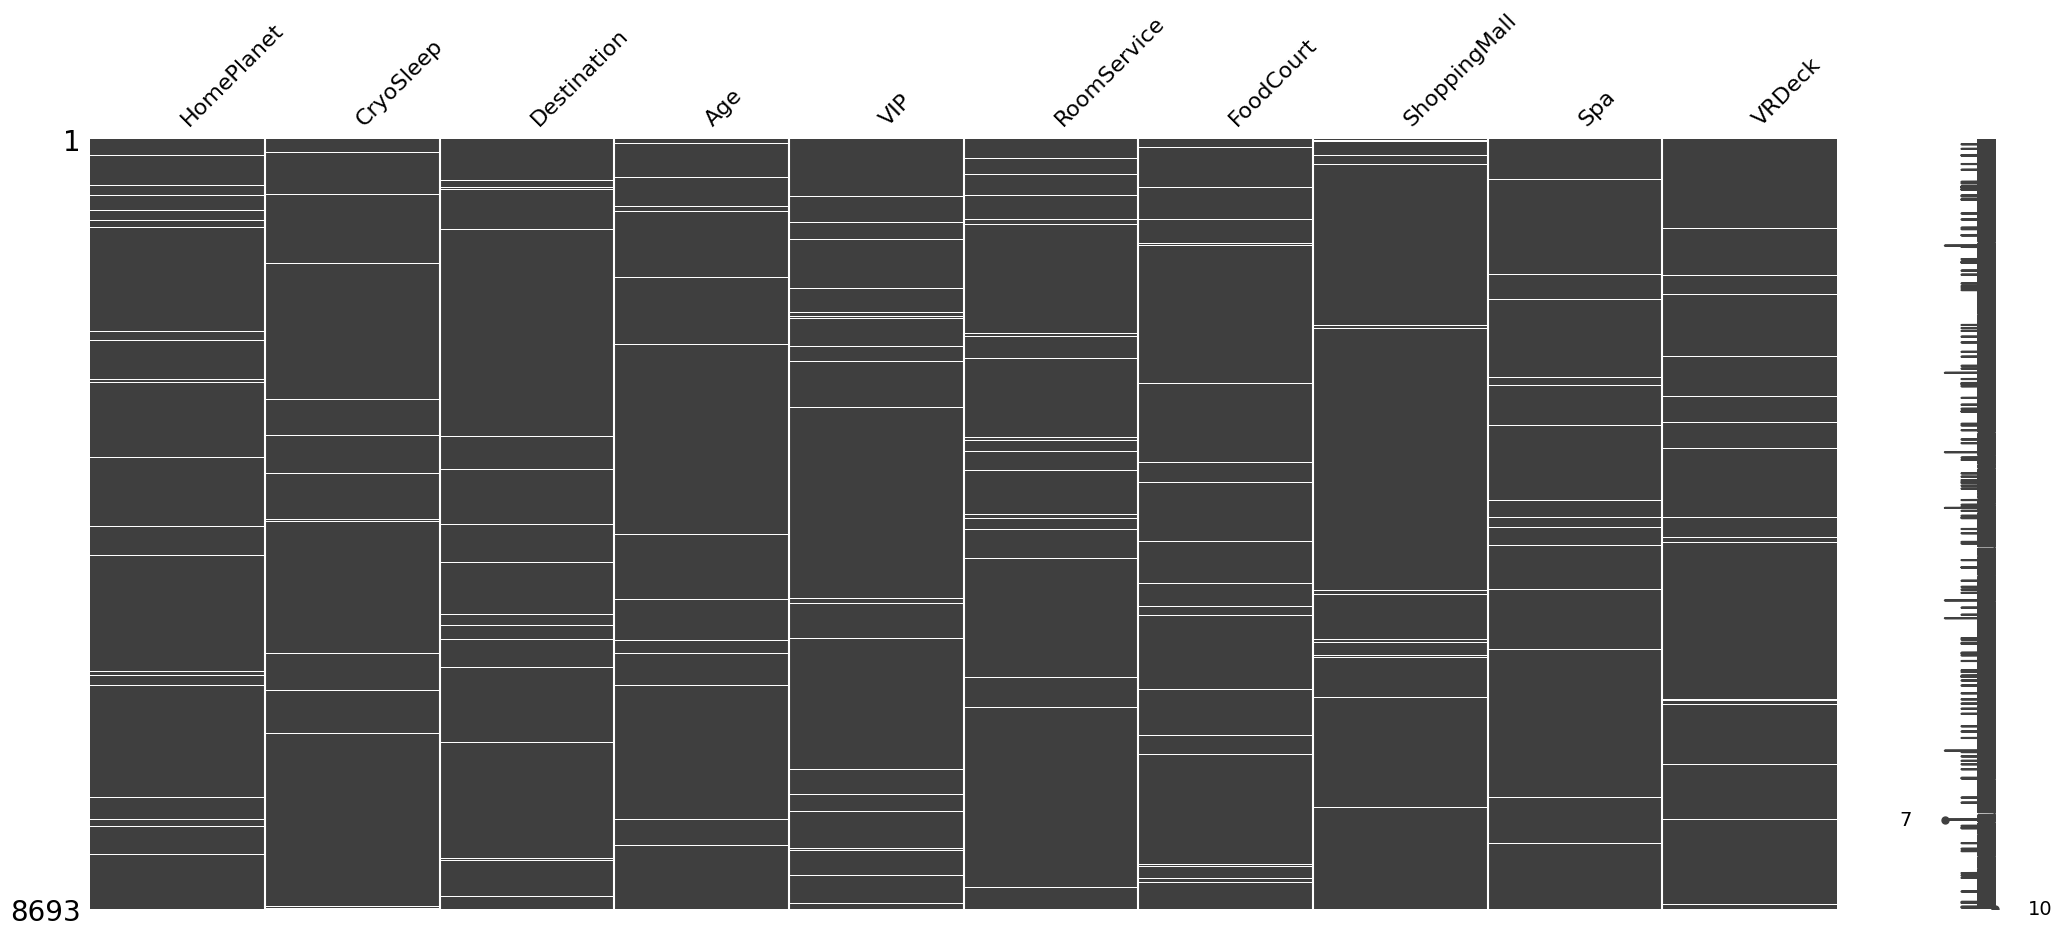

In [6]:
msno.matrix(df)
plt.show()

## **Dealing with MCAR**

Handling Missing Completely At Random (MCAR) data is relatively straightforward, as the missing values are unrelated to the observed or unobserved data. Here are common approaches to manage MCAR data:

## **Delete Missing Data (Listwise Deletion)**



- **What**: Remove rows or columns with missing values.
- **When to Use**:
  - When the percentage of missing data is **very low** (e.g., < 5%).
  - When deleting data does not lead to loss of critical information.
- **Advantages**:
  - Simple and easy to implement.
  - No assumptions about the missingness mechanism.
- **Disadvantages**:
  - May reduce the dataset size and statistical power.
  - Can introduce bias if the data was not actually MCAR.

In [7]:
# Size of the original data
original_data_size = df.shape[0]

# Data with removed null values
removed_null = df.dropna()
removed_null_data_size = removed_null.shape[0]

# Percentage of data lost
values_lost = original_data_size - removed_null_data_size
percentage_lost = round((values_lost / original_data_size) * 100, 3)

print(f"Total number of data sampels lost   : {values_lost}")
print(f"Percentage of data lost             : {percentage_lost}%")

Total number of data sampels lost   : 1770
Percentage of data lost             : 20.361%


If we simply get rid of the entire missing data then we will technically loose around 24% of the data, this is something we would not like to do with the data.

---

You might wonder why we didn't remove the columns with missing data instead of the rows. The answer is straightforward: almost all columns contain some missing data, so removing them would result in losing nearly all of our data.

### **Simple Imputation Techniques**

#### **Numerical Data - Mean & Median Imputation**

- Replace missing values with simple statistical measures such as:
  - **Mean**: Suitable for continuous data.
  - **Median**: Better for skewed continuous data.
  - **Mode**: Suitable for categorical data.

- **When to Use**:
  - When missing values are randomly distributed (MCAR).
  - When the percentage of missing data is moderate (e.g., 5–20%).

---
In order to use this we would like to know exactly what is the data type of the feature, not just numerical or categorical but we would like to know where it is discrete or continuous.

In [8]:
# Numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns

# Categorical features
categorical_features = df.select_dtypes(exclude=[np.number]).columns

In [9]:
# Differentiate between continuous & discrete
for feature in numerical_features:

    # Plot a histogram
    fig = px.histogram(df, x=feature, nbins=30)
    fig.update_layout(
        title=f"Histogram of {feature}",
        xaxis_title=feature,
        yaxis_title="Frequency",
    )
    fig.show()

In this scenario, we are working with continuous data, and our primary concern is selecting an appropriate imputation technique. Since mode imputation is unsuitable for continuous data, we are left with two viable options: **mean imputation** or **median imputation**.

The choice between these two methods depends on the distribution of the data:
- **Mean Imputation**: Preferred when the data is symmetrically distributed, as it minimizes distortion in the central tendency.
- **Median Imputation**: More robust for skewed distributions, as it is less affected by outliers.

Careful consideration of the data's characteristics is essential to ensure the chosen imputation method preserves the integrity and statistical properties of the dataset.

---

In this case, the only feature that is roughly symetrically distributed "Age", so we will use mean imputation for "Age" and median imputation for others.

In [10]:
# Copy the original data
df_copy = df.copy()

# Mean Imputation
df_copy["Age"] = df_copy["Age"].fillna(df_copy["Age"].mean())

# Median Imputation
for feature in numerical_features[1:]:
    df_copy[feature] = df_copy[feature].fillna(df_copy[feature].median())

In [11]:
# Check again for null values
df_copy.isnull().sum()

HomePlanet      201
CryoSleep       217
Destination     182
Age               0
VIP             203
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
dtype: int64

#### **Categorical Data - Mode Imputation**

We still need to address the missing values in the categorical data. For categorical variables, we have two practical imputation options:

1. **Create a New "Missing" Category**: Introduce a new category (e.g., "Missing" or "Unknown") to explicitly represent the missing values. This approach is particularly useful when the absence of data itself carries meaningful information.

2. **Mode Imputation**: Replace missing values with the most frequently occurring category (mode) in the dataset. This method is effective when the missingness is likely random and does not hold significant contextual meaning.

The choice between these methods should be guided by the context of the dataset and the potential impact on downstream analyses.


---

When the missing data constitutes only **2% per categorical feature**, the proportion of missingness is relatively low. In such cases, **mode imputation** is generally the preferred choice because:

- It is straightforward and does not introduce an entirely new category, which might not hold any real significance given the small percentage of missing values.
- It minimizes potential distortion while maintaining the dataset's statistical properties.

However, if the missing values could carry some implicit meaning (e.g., "Unknown" or "Not Provided"), creating a new "Missing" category could also be considered. For a 2% missing rate, mode imputation is typically sufficient and more practical unless domain knowledge suggests otherwise.

In [12]:
print(f"Categorical Features: {list(categorical_features)}")

Categorical Features: ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']


In [13]:
# Model imputation for categorical data
for feature in categorical_features:
    df_copy[feature] = df_copy[feature].fillna(df_copy[feature].mode()[0])

In [14]:
# Check for confirmation
df_copy.isnull().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

### **Do Nothing (When Missing Data Is Ignored)**

- Some machine learning algorithms (e.g., tree-based models like Random Forests or XGBoost) can handle missing values internally.
- **When to Use**:
  - When your algorithm supports missing values.
  - When missing values are a feature of the dataset (e.g., "absence" is meaningful).


## **Final Words**


Missing Completely At Random (MCAR) means the missing data is unrelated to any observed or unobserved values—it might have been lost due to collection process issues, errors in collection instruments, or external factors. Since there's no bias or pattern causing the missing data, it can be easily imputed using simple techniques like median or mode imputation. Advanced imputation methods aren't necessary for MCAR data, as simpler methods suffice.

For Missing At Random (MAR) data, the missingness is related to other observed variables. This makes it more complex to handle, and advanced imputation techniques like K-Nearest Neighbor (KNN) or Multiple Imputation are often needed. While these techniques can also be used for MCAR data, their impact isn't as significant, so it's more efficient to stick with basic methods. Mean imputation is generally not recommended as it might introduce bias. Instead, focus on median or mode imputation.


# **MAR**

For explaination refer introduction.

## **Detecting MAR Data**

> **Rule of Thumb**:  

"Assume **Missing at Random (MAR)** over **Missing Completely at Random (MCAR)** when analyzing data, as any analysis valid under the MCAR assumption will also hold under MAR, but the reverse is not true."  

---

When dealing with a dataset with missing values, a general rule of thumb is to consider them as Missing At Random (MAR) since this is more likely. The techniques used for MAR are also valid for Missing Completely At Random (MCAR), so there's no issue in this assumption. However, in some cases, we can visually detect MAR data using visualization techniques. Let's create some synthetic data to explore this further.


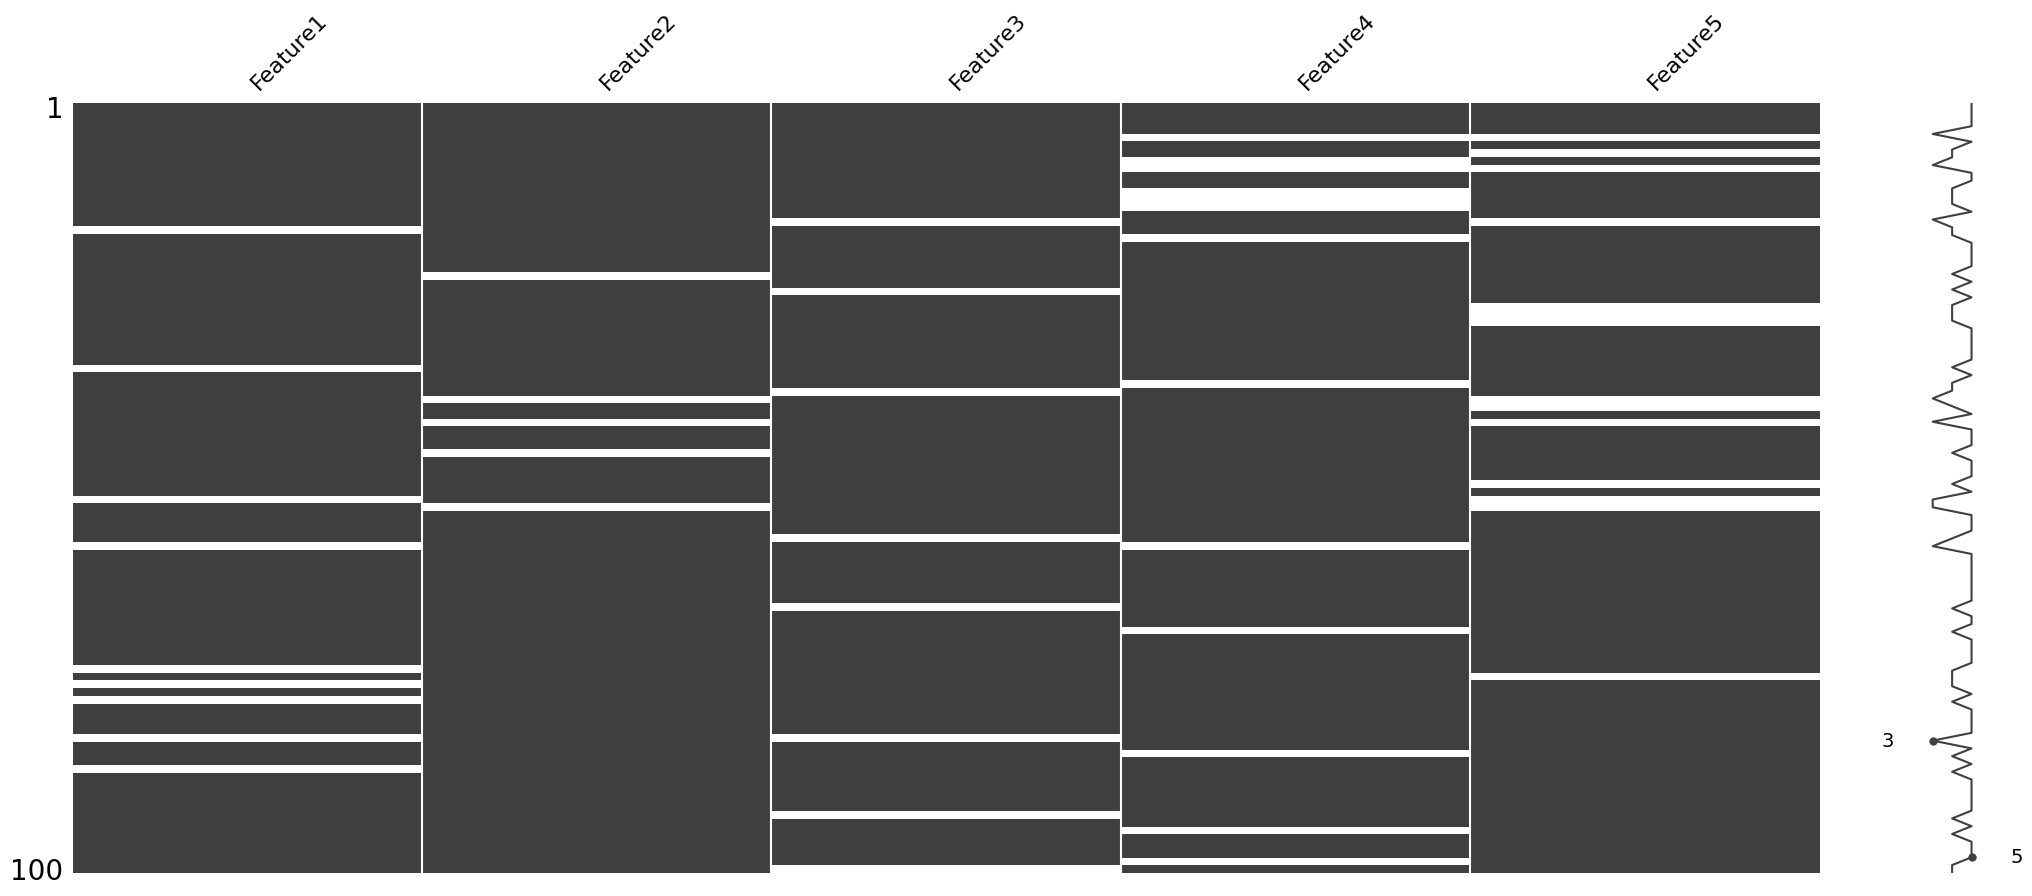

In [15]:
# Generate a synthetic dataset with 100 rows and 5 columns
data = {
    "Feature1": np.random.randint(10, 100, 100),
    "Feature2": np.random.uniform(1.0, 10.0, 100),
    "Feature3": np.random.choice(["A", "B", "C", "D"], 100),
    "Feature4": np.random.normal(50, 15, 100),
    "Feature5": np.random.randint(0, 2, 100),
}

# Convert to a DataFrame
fake_df = pd.DataFrame(data)

# Introduce missing values completely at random (MCAR)
# Choose 10% of the data (randomly selected) to set as NaN
missing_fraction = 0.1
num_missing = int(np.floor(missing_fraction * fake_df.size))

# Randomly select indices in the dataset to be missing
missing_indices = [
    (row, col)
    for row in np.random.choice(fake_df.index, num_missing)
    for col in np.random.choice(fake_df.columns, 1)
]

# Set the selected indices to NaN
for row, col in missing_indices:
    fake_df.loc[row, col] = np.nan

# Check for MAR via MNO
msno.matrix(fake_df)
plt.show()


In this visualization, we can clearly observe that the missing values tend to be grouped together, with high density areas indicating multiple missing values at the same locations. This suggests that the data may not be Missing Completely At Random (MCAR), but rather Missing At Random (MAR). When you notice these clustered patterns in the heatmap or the `missingno` matrix, it indicates MAR, suggesting the need for advanced imputation techniques to handle this data.


In [16]:
# Select only numerical features
fake_df_nums = fake_df.select_dtypes(include=[np.number])

# Initialize the MCAR test
mt = MCARTest(method="little")

# Check for MCAR Value
p_value = mt.little_mcar_test(fake_df_nums)

# Null Hypothesis: Missing data is MCAR
alpha = 0.05                    # Significance level
print(f"P-value: {p_value}")

if p_value > alpha:
    print("Fail to reject the null hypothesis: The missing data is likely MCAR.")
else:
    print("Reject the null hypothesis: The missing data is NOT MCAR (it may be MAR or MNAR).")

P-value: 0.13899725852046707
Fail to reject the null hypothesis: The missing data is likely MCAR.


In this case, the p-value is approximately 0.14. Since this is higher than the 0.05 threshold, we fail to reject the null hypothesis, indicating the data is likely Missing Completely At Random (MCAR). Note that the p-value here is lower than previously seen values, so it's not a strict threshold.

However, if the p-value is around 0.1, you might consider that the data could potentially be Missing At Random (MAR) instead of MCAR. This is not an exact rule but can still be useful. While there's no specific statistical test for MAR, this approach can provide additional insights alongside general rules of thumb.

**Remember, there isn't a specific statistical test to confirm MAR, so combining these insights with visualization techniques and correlation analysis can provide a more comprehensive understanding.**

# **Hot Deck Imputation**

Hot Deck Imputation is a technique used to handle missing data by filling in the missing values with observed values from similar records within the dataset. The basic idea is to "borrow" information from "donor" records that have similar characteristics to the "recipient" records with missing values. It can provide more accurate imputations compared to simple methods like mean imputation by preserving the variability and structure of the data.

Types of Hot Deck Imputation:

1. **Random Hot Deck Imputation:**
   - The missing value is filled with a randomly selected observed value from similar records (i.e., donor records).
   - It ensures that the imputed values reflect the variability in the data.

2. **Deterministic Hot Deck Imputation:**
   - Involves systematic methods like carrying forward or backward the last observed value, or using specific rules to select donor values.
   - **Forward Fill:** Fills missing values with the last observed value.
   - **Backward Fill:** Fills missing values with the next observed value.
   - **K-Nearest Neighbors (KNN):** Uses the values of the k-most similar records to impute the missing value.
   - **Linear Regression:** Imputes missing values by predicting them based on a linear relationship with other variables.

Advantages:

- **Preserves Data Structure:** Maintains the distribution and relationships within the data.
- **Versatility:** Can be applied to both categorical and continuous data.
- **Flexibility:** Allows for the use of various methods to find donor values, depending on the data and context.

Disadvantages:

- **Potential Bias:** If the selection of donor records is not representative, it may introduce bias.
- **Computationally Intensive:** More complex methods like KNN can be computationally demanding.
- **Data Dependency:** Relies heavily on the availability of similar donor records with complete data.

Steps in Hot Deck Imputation:

1. **Identify Similar Records:** Find records in the dataset that are similar to the one with missing values.
2. **Select Donor Values:** Choose a donor value from these similar records, either randomly or based on a specific rule.
3. **Impute Missing Values:** Replace the missing value with the selected donor value.

## **Random Hot-Deck Imputation**

Random hot deck imputation operates on a **per-feature basis**, aligning with its design and definition. Unlike methods such as deletion, which can be applied across both rows and columns, hot deck imputation specifically targets individual features for imputing missing values.

The process involves partitioning the data into two groups:
1. **Donor Pool**: A subset of observed (non-missing) values within the feature, which serve as the source for imputation.
2. **Recipient Values**: The missing values in the feature that require imputation.

For each missing value, a random **donor value** is sampled from the observed donor pool and used to replace the missing entry. This iterative process continues until all missing values in the feature are imputed, leveraging randomness to preserve variability while maintaining the feature's statistical properties.

In [17]:
def random_hot_deck_imputation(data_frame, feature):

    # Create a copy of the original df
    data_frame = data_frame.copy()

    # Select the Observed Values / Donors
    donor_pool = data_frame[data_frame[feature].notnull()][feature]

    # Select the Missing Values / Recipients
    missing_values = data_frame[data_frame[feature].isnull()][feature]

    # Loop over each missing value
    for i in missing_values.index:

        # Randomly select a donor value from the donor pool
        donor_value = np.random.choice(donor_pool)

        # Replace the missing value with the randomly selected donor value
        data_frame.loc[i, feature] = donor_value

    return data_frame

In [18]:
# Create a sample from the original data
df_sample = df.sample(1000).copy()

# Example: Age
prev_null_values = df_sample.Age.isnull()
prev_null_count = df_sample.Age.isnull().sum()

# Apply Random Hot deck imputation
df_sample_imputed = random_hot_deck_imputation(df_sample, "Age")

# Check for null values
new_null_count = df_sample_imputed.Age.isnull().sum()

print(f"Null Count (before Imputation): {prev_null_count}")
print(f"Null Count (after Imputation) : {new_null_count}")

Null Count (before Imputation): 17
Null Count (after Imputation) : 0


In [19]:
# Lets compare the results of the imputation
df_sample[prev_null_values].head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
5349,Earth,True,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0
5003,Mars,False,TRAPPIST-1e,NaN,False,134.0,0.0,6.0,1450.0,0.0
5488,Europa,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0
7244,Europa,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0
6765,Mars,True,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0


In [20]:
df_sample_imputed[prev_null_values].head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
5349,Earth,True,TRAPPIST-1e,46.0,False,0.0,0.0,0.0,0.0,0.0
5003,Mars,False,TRAPPIST-1e,61.0,False,134.0,0.0,6.0,1450.0,0.0
5488,Europa,True,55 Cancri e,3.0,False,0.0,0.0,0.0,0.0,0.0
7244,Europa,True,55 Cancri e,50.0,False,0.0,0.0,0.0,0.0,0.0
6765,Mars,True,TRAPPIST-1e,18.0,False,0.0,0.0,0.0,0.0,0.0


**Merits of Random Hot Deck Imputation**  


1. **Preserves Data Distribution**  
   - Random hot deck imputation ensures that the imputed values come from the observed data, preserving the original distribution and variability of the feature.

2. **Adaptable to Data Types**  
   - It is suitable for both continuous and categorical features, as it directly samples existing values.

3. **Minimizes Bias**  
   - Since donor values are randomly selected from the observed pool, it reduces systematic bias compared to deterministic methods like mean or median imputation.

4. **Handles Small Missingness Proportions Well**  
   - Works effectively when the proportion of missing values is low, as the observed donor pool remains representative of the underlying data.

5. **No Complex Assumptions**  
   - Does not require assumptions about the underlying data structure or distribution, making it a straightforward and flexible approach.

---

**Demerits of Random Hot Deck Imputation**  


1. **Random Noise Introduction**  
   - The random selection process can introduce additional variability, potentially impacting the results if the dataset is small or the missingness is substantial.

2. **Requires Sufficient Donors**  
   - The technique relies on a robust pool of donor values. If the observed data is sparse or highly imbalanced, the imputation may not be representative.

3. **Loses Contextual Relationships**  
   - Random selection does not account for relationships or dependencies between features, which can lead to inconsistencies in datasets with correlated variables.

4. **Not Scalable for Large Datasets**  
   - Random sampling for each missing value can become computationally expensive for large datasets with significant missingness.

5. **Potential Overfitting Risk in Small Datasets**  
   - Randomly sampled values may not generalize well if the dataset is small, leading to overfitting during model training.

6. **No Guarantee of Optimality**  
   - Unlike model-based imputations (e.g., k-NN, regression), random hot deck imputation does not optimize for the best fit or prediction accuracy.

---

**When to Use**  

Random hot deck imputation is best suited for:
- Datasets with low missingness (<10% per feature).
- Situations where preserving the original distribution of the feature is important.
- Scenarios where computational simplicity is preferred over more complex model-based imputation methods.

For datasets with high missingness or strong inter-feature dependencies, more advanced imputation techniques may be more appropriate.

## **Deterministic Hot-Deck Imputation**

### **Value/Instance Based**

#### **Forward Fill**

Forward fill is a simple imputation method where missing values in a dataset are replaced with the last observed (non-missing) value in the same column. This method is commonly used for time-series or sequential data, where the assumption is that the most recent observation is a reasonable approximation for the missing value.

---

**Example**:


Input Data:

```
   Time  Value
0     1   10.0
1     2    NaN
2     3    NaN
3     4   15.0
4     5    NaN
5     6   20.0
```

After Forward Fill:

```
   Time  Value
0     1   10.0
1     2   10.0
2     3   10.0
3     4   15.0
4     5   15.0
5     6   20.0
```

---

**How It Works**:

- At `Time = 2`, the missing value is replaced with `10.0` (last observed value from `Time = 1`).
- At `Time = 3`, the missing value is again replaced with `10.0`.
- At `Time = 5`, the missing value is replaced with `15.0` (last observed value from `Time = 4`).

---

**Use Cases**:

- **Time-Series Data**: Imputing gaps in measurements or stock prices.
- **Sequential Data**: Handling missing values where data order matters.

In [21]:
# Create a Copy
df_copy = df.copy()

# Forward Fill
df_copy = df_copy.ffill()
df_copy.isnull().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

**Forward Fill (FFILL) Imputation**


**Merits**

1. **Simplicity**:
   - Easy to implement with minimal computational cost.
   - No complex algorithms or additional assumptions are needed.

2. **Preserves Temporal Order**:
   - Retains the natural sequence of time-series or sequential data by filling gaps based on previous observations.

3. **Useful for Certain Domains**:
   - Works well in scenarios where values are expected to remain constant or change gradually over time (e.g., sensor readings, stock prices).

4. **Prevents Data Loss**:
   - Avoids discarding rows or columns with missing values, preserving the dataset for further analysis.

---

**Demerits**

1. **Not Suitable for Non-Sequential Data**:
   - Assumes that the last observed value is relevant for filling missing values, which may not be true for non-sequential or unordered datasets.

2. **Risk of Bias**:
   - If missing values occur frequently or over long gaps, forward fill can propagate outdated values, introducing bias.

3. **Fails for Initial Missing Values**:
   - Does not address missing values at the start of a dataset, as no prior value exists to fill them.

4. **Inappropriate for Volatile Data**:
   - May not work well for datasets with high variability or sudden changes, as it cannot capture the dynamics of such patterns.

---

**When to Use Forward Fill**

1. **Time-Series or Sequential Data**:
   - Works well for datasets where values change gradually over time (e.g., weather data, stock prices, or machine sensor readings).

2. **Short Gaps in Data**:
   - Effective when missing values occur sporadically or in small gaps, as the most recent observation is likely to be a reasonable approximation.

3. **Data with Constant or Slowly Varying Trends**:
   - Ideal for datasets where values remain stable or vary slowly over time.

4. **When Computational Simplicity is Needed**:
   - Suitable for quick preprocessing or when advanced imputation methods are unnecessary.

---

**Example of When Not to Use**

- **Categorical Data**: Forward fill may propagate an unrelated category value.
- **Highly Volatile Data**: In financial trading data with rapid fluctuations, forward fill may misrepresent actual trends.

---

**Alternatives**

- **Backward Fill (BFill)**: Uses the next observed value instead of the previous one.
- **Interpolation**: Fills missing values using trends or patterns (e.g., linear or polynomial).
- **Model-Based Imputation**: Uses algorithms to predict missing values based on relationships in the data.

#### **Backward Fill**

It is similar to forward will, it just works in backward order.

In [22]:
# Create a Copy
df_copy = df.copy()

# Forward Fill
df_copy = df_copy.bfill()
df_copy.isnull().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

#### **KNN Imputer**

In [23]:
# Intialize & Run Label Encoder
le = LabelEncoder()
for feature in categorical_features:
    df[feature] = le.fit_transform(df[feature])

df.head()

# Create a copy of the original data
df_sample = df.copy()

---

**Note:** In this example, I'm using a label encoder for simplicity. There are various methods to encode categorical features into numeric values, such as ordinal encoding, sine-cosine encoding, and more complex techniques like M estimates encoder and mean encoding. However, our focus here is on handling missing values rather than comparing different encoding methods. While label encoding may not provide the best performance in all cases, it's sufficient for this demonstration. For a detailed overview of different encoding methods and their usage, please refer to the provided notebook.

---

In [24]:
# Initialize KNN Imputer
imputer = KNNImputer(n_neighbors=5)

# Impute missing values
df_imputed = imputer.fit_transform(df_sample)

# Inspective data
df_imputed = pd.DataFrame(df_imputed, columns=df_sample.columns)
df_imputed.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,1.0,0.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,2.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0
2,1.0,0.0,2.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0
3,1.0,0.0,2.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0
4,0.0,0.0,2.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0


In [25]:
# Check for null values
df_imputed.isnull().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

In [26]:
# Compare some random data with the null data
df[df.isnull().any(axis=1)].head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
7,0,1,2,28.0,0,0.0,0.0,0.0,0.0,NaN
10,1,1,2,34.0,0,0.0,0.0,NaN,0.0,0.0
16,2,0,0,27.0,0,1286.0,122.0,NaN,0.0,0.0
23,0,1,0,29.0,0,0.0,0.0,NaN,0.0,0.0
25,0,1,1,1.0,0,NaN,0.0,0.0,0.0,0.0


In [27]:
df_imputed[df.isnull().any(axis=1)].head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
7,0.0,1.0,2.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1.0,1.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0
16,2.0,0.0,0.0,27.0,0.0,1286.0,122.0,256.2,0.0,0.0
23,0.0,1.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


One advantage of the K-Nearest Neighbor (KNN) algorithm is its ability to handle both categorical and numerical values. Although categorical data is ultimately converted to numerical form, KNN can be applied to different types of data without needing to fit each specific column individually. This method effectively addresses missing values by identifying patterns within the data, allowing you to preserve more information.


**Merits**

1. **Captures Relationships in Data**:
   - Uses information from multiple features to fill missing values, preserving inter-feature correlations.

2. **Customizable**:
   - The number of neighbors (`k`) and the distance metric (e.g., Euclidean, Manhattan) can be adjusted to suit the dataset and imputation needs.

3. **Works for Both Numerical and Categorical Data**:
   - Can handle both data types by using appropriate distance metrics.

4. **Preserves Data Variability**:
   - By imputing based on similar rows, KNN maintains the variability of the dataset instead of using static values like mean or median.

5. **Handles Complex Patterns**:
   - Effective for datasets with non-linear relationships, where simpler imputation methods may fail.

---

**Demerits**

1. **Computationally Intensive**:
   - KNN requires calculating distances between all data points, making it slow for large datasets, especially with many missing values.

2. **Sensitive to Feature Scaling**:
   - The imputation depends on the distance metric, so features must be scaled (e.g., using MinMaxScaler or StandardScaler) to ensure fair comparisons.

3. **Assumes Similarity is Meaningful**:
   - Relies on the assumption that nearby data points (in terms of distance) are similar enough to infer missing values, which may not hold for all datasets.

4. **Can Introduce Noise**:
   - If the nearest neighbors are noisy or not representative, the imputed values may be inaccurate.

5. **Complex to Tune**:
   - Choosing the right number of neighbors (`k`) and an appropriate distance metric can require trial and error.

---

**When to Use KNN Imputation**

1. **Data with Strong Inter-Feature Relationships**:
   - Suitable for datasets where missing values can be inferred based on other features.

2. **Low to Moderate Missingness**:
   - Works well when missing values are limited to a reasonable percentage (<30%) of the dataset.

3. **Small to Medium-Sized Datasets**:
   - Ideal for datasets where the computational cost of calculating distances is manageable.

4. **Numerical and Categorical Data**:
   - Use appropriate distance metrics (e.g., Hamming for categorical) to ensure accuracy.

5. **When Accuracy is Crucial**:
   - If maintaining inter-feature relationships and producing high-quality imputation is critical, KNN is a strong choice.

---

**Example of When Not to Use**

- **High Missingness**: Sparse datasets may lack sufficient neighbors for meaningful imputation.
- **Large Datasets**: KNN can be computationally prohibitive for millions of rows or high-dimensional data.
- **Weakly Correlated Features**: If features are independent, the neighbors' values may not be relevant for imputation.

---

**Alternatives**

- **Mean/Median/Mode Imputation**: Simpler but less accurate methods for low-dimensional or weakly correlated data.
- **Iterative Imputer**: A model-based approach that uses machine learning algorithms to predict missing values.
- **Matrix Factorization**: Suitable for high-dimensional data, such as recommendation systems or collaborative filtering.


In [28]:
# Effect of scaling
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df_sample), columns=df_sample.columns)
scaled_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.325245,-0.741736,0.577024,0.702095,-0.208465,-0.337025,-0.284274,-0.287317,-0.273736,-0.266098
1,-0.833031,-0.741736,0.577024,-0.333233,-0.208465,-0.173528,-0.278689,-0.245971,0.209267,-0.227692
2,0.325245,-0.741736,0.577024,2.013510,2.786879,-0.272527,1.934922,-0.287317,5.634034,-0.223327
3,0.325245,-0.741736,0.577024,0.287964,-0.208465,-0.337025,0.511931,0.326250,2.655075,-0.097634
4,-0.833031,-0.741736,0.577024,-0.885407,-0.208465,0.117466,-0.240833,-0.037590,0.223344,-0.264352


In [29]:
# Apply KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)
scaled_df_imputed = knn_imputer.fit_transform(scaled_df)

# Convert to dataframe
scaled_df_imputed = pd.DataFrame(scaled_df_imputed, columns=df_sample.columns)

In [30]:
# Affect of scaling on imputation
df_imputed[df.isnull().any(axis=1)].head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
7,0.0,1.0,2.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1.0,1.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0
16,2.0,0.0,0.0,27.0,0.0,1286.0,122.0,256.2,0.0,0.0
23,0.0,1.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
data = scaler.inverse_transform(scaled_df_imputed[df.isnull().any(axis=1)].head())
pd.DataFrame(data, columns=df_sample.columns).head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.0,1.0,2.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,27.0,0.0,1286.0,122.0,87.6,0.0,0.0
3,0.0,1.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
df[df.isnull().any(axis=1)].head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
7,0,1,2,28.0,0,0.0,0.0,0.0,0.0,NaN
10,1,1,2,34.0,0,0.0,0.0,NaN,0.0,0.0
16,2,0,0,27.0,0,1286.0,122.0,NaN,0.0,0.0
23,0,1,0,29.0,0,0.0,0.0,NaN,0.0,0.0
25,0,1,1,1.0,0,NaN,0.0,0.0,0.0,0.0


When comparing the two cases, the significantly different values for index 16 illustrate how scaling affects imputation.

---

> **How to choose "k"?**

The choice of `k` in KNN imputation depends on dataset size, feature relationships, and the amount of missing data. Smaller `k` values (e.g., 2–5) are better for small datasets or when features are weakly correlated, as they focus on local patterns. Larger `k` values (e.g., 5–10) work well for large datasets or when features have strong correlations, as they incorporate more diverse neighbors. To select `k`, simulate missing data, test multiple `k` values, and use error metrics like RMSE or MAE to evaluate performance. Cross-validation and domain knowledge can guide the optimal choice.

### **Model Based**

#### **Linear Regression**

Linear regression relies on using data without missing values to predict the values of features with missing values. If all features contain missing values, this method isn't viable. However, if only some features have missing values, linear regression can be applied effectively. In cases where all features have missing values, it's better to use more advanced imputation methods, such as Multiple Imputation by Chained Equations (MICE).

In [33]:
df.isnull().sum()

HomePlanet        0
CryoSleep         0
Destination       0
Age             179
VIP               0
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
dtype: int64

In this case, each feature contains missing values, making linear regression unsuitable. For demonstration purposes, we'll use "ffill" to handle some features, and then apply linear regression to impute the remaining missing values.

In [34]:
# Create a copy
df_copy = df.copy()

# set target feature
target_feature = "Age"

# Apply ffill on all features except target feature
for feature in df_copy.columns:
    if feature != target_feature:
        df_copy[feature] = df_copy[feature].ffill()

# Check for null values
df_copy.isnull().sum()

HomePlanet        0
CryoSleep         0
Destination       0
Age             179
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
dtype: int64

In [35]:
# Data with missing values
df_missing = df_copy[df_copy.isnull().any(axis=1)]
df_missing = df_missing.drop(target_feature, axis=1)

In [36]:
# Drop rows with null values
df_cleaned = df_copy.dropna()

# Separating Xs & Ys
X = df_cleaned.drop(target_feature, axis=1)
y = df_cleaned[target_feature]

In [37]:
# Initialize a Linear Regression Model
model = LinearRegression()

# Fit the model
model.fit(X, y)

LinearRegression()

In [38]:
# Model Predictions
y_pred = model.predict(df_missing)
y_pred = pd.DataFrame(y_pred, columns=[target_feature], index=df_missing.index)

In [39]:
missing_sample = df_copy.isnull().any(axis=1)

# Original Missing data
df_copy[missing_sample].head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
50,0,0,2,NaN,0,4.0,0.0,2.0,4683.0,0.0
64,2,0,2,NaN,0,793.0,0.0,2.0,253.0,0.0
137,0,1,0,NaN,0,0.0,0.0,0.0,0.0,0.0
181,1,0,0,NaN,0,0.0,2433.0,0.0,878.0,443.0
184,1,0,0,NaN,0,2.0,1720.0,12.0,1125.0,122.0


In [40]:
# Impute these values at the right index
df_copy.loc[df_missing.index, target_feature] = y_pred
df_copy[missing_sample].head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
50,0,0,2,31.681012,0,4.0,0.0,2.0,4683.0,0.0
64,2,0,2,31.107885,0,793.0,0.0,2.0,253.0,0.0
137,0,1,0,25.793867,0,0.0,0.0,0.0,0.0,0.0
181,1,0,0,31.305100,0,0.0,2433.0,0.0,878.0,443.0
184,1,0,0,30.781792,0,2.0,1720.0,12.0,1125.0,122.0


The results obtained using linear regression for imputation are not satisfactory. This is expected, as linear regression is a basic machine learning model that may fail to capture complex relationships in the data. As a result, it struggles to predict values like "age" with high accuracy. Improving the model could yield better results, but that shifts the focus to model enhancement rather than imputation itself. While linear regression is commonly used for imputation, its effectiveness can be improved by adding randomness or noise to the predictions. This approach is known as stochastic regression imputation.

#### **Stochastic Regression Imputation**

Stochastic regression imputation is an advanced technique for handling missing data by combining predictions from a regression model with added randomness to account for uncertainty. In this method, a regression model (e.g., linear regression) is trained on observed data to predict the missing values for a target feature. To reflect the natural variability in the data, random noise, based on the standard error of the model's residuals, is added to the predictions. This ensures that the imputed values are not overly deterministic and better represent the inherent randomness of real-world data. Stochastic regression imputation is particularly useful when aiming to retain the data's variability while addressing missing values.

In [41]:
def stochastic_regression_imputation(df, feature):
    # Create a copy of the DataFrame to avoid modifying the original data
    data = df.copy()

    # Separate rows with observed and missing values for the target feature
    observed = data[data[feature].notnull()]
    missing = data[data[feature].isnull()]

    # Identify predictor columns (all columns except the target feature)
    predictors = [col for col in data.columns if col != feature]

    # Train a regression model on the observed data
    model = LinearRegression()
    model.fit(observed[predictors], observed[feature])

    # Predict missing values using the regression model
    predictions = model.predict(missing[predictors])

    # Calculate the standard error of the predictions
    residuals = observed[feature] - model.predict(observed[predictors])
    std_error = residuals.std()

    # Add stochastic noise (random normal distribution) to the predictions
    stochastic_predictions = predictions + np.random.normal(0, std_error, size=predictions.shape)

    # Update the missing values with the stochastic predictions
    data.loc[missing.index, feature] = stochastic_predictions

    return data

In [42]:
# Copy the original data
df_copy = df.copy()
df_copy.isnull().sum()

HomePlanet        0
CryoSleep         0
Destination       0
Age             179
VIP               0
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
dtype: int64

In this case, multiple features contain missing values, which can complicate the use of linear regression for imputation. Since stochastic regression imputation is essentially an enhanced version of linear regression with added randomness, it works best when applied to a single target feature at a time. To address this, we first use forward fill to impute other features and focus on imputing the target feature (e.g., "Age") with stochastic regression.

In [43]:
# Set the target feature as age
target_feature = "Age"

# Apply forward fill to the rest of the feature
for feature in df_copy.columns:
    if feature != target_feature:
        df_copy[feature] = df_copy[feature].ffill()

In [44]:
# Originally missing data
df_copy[missing_sample].head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
50,0,0,2,NaN,0,4.0,0.0,2.0,4683.0,0.0
64,2,0,2,NaN,0,793.0,0.0,2.0,253.0,0.0
137,0,1,0,NaN,0,0.0,0.0,0.0,0.0,0.0
181,1,0,0,NaN,0,0.0,2433.0,0.0,878.0,443.0
184,1,0,0,NaN,0,2.0,1720.0,12.0,1125.0,122.0


In [45]:
# Apply stochastic regression imputation to the target feature
df_imputed = stochastic_regression_imputation(df_copy, target_feature)
df_imputed[missing_sample].head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
50,0,0,2,34.109767,0,4.0,0.0,2.0,4683.0,0.0
64,2,0,2,34.550311,0,793.0,0.0,2.0,253.0,0.0
137,0,1,0,17.365054,0,0.0,0.0,0.0,0.0,0.0
181,1,0,0,33.311786,0,0.0,2433.0,0.0,878.0,443.0
184,1,0,0,35.803709,0,2.0,1720.0,12.0,1125.0,122.0


The improvements in the imputed values, particularly for "age," using stochastic regression imputation are evident. By incorporating noise into the model's predictions, we not only enhance their accuracy but also ensure that the imputed values fall within a realistic range. In contrast to the previous approach, where a simple linear regression model produced out-of-range results, the addition of randomness helps maintain the data's natural variability while aligning predictions with the expected range of values. This demonstrates the effectiveness of stochastic regression imputation in addressing the limitations of basic regression models for imputation tasks.

Merits

1. **Improves Data Quality**: By incorporating randomness, it avoids imputing the same value for all missing entries, maintaining the natural variability in the data.
2. **Bias Reduction**: Helps to reduce bias that can occur with deterministic methods, leading to more accurate and robust models.
3. **Preserves Relationships**: Maintains the relationships among variables, improving the overall integrity of the dataset.

Demerits

1. **Computationally Intensive**: Requires more computational power and time compared to simpler imputation methods.
2. **Complexity**: Can be more complex to implement and understand, requiring a good grasp of statistical methods.
3. **Uncertainty**: Introduces an element of randomness, which might lead to different results with each run, complicating reproducibility.

When to Use?

- **Moderate to High Missing Data**: Useful when there is a moderate to high amount of missing data and maintaining variability is crucial.
- **Data Integrity**: When it is important to preserve the relationships among variables to ensure the accuracy of downstream analyses.
- **Advanced Analysis**: Suitable for more advanced analyses where simple imputation methods may not suffice, and a higher level of accuracy is required.

Stochastic Regression Imputation can be a powerful tool, especially when the nuances of the data are critical to the outcomes of the analysis. Its use, however, should be balanced against its complexity and computational demands.

Is there a specific application or dataset you have in mind for this method?

#### **Multivariate Imputation by Chained Equations (MICE)**

MICE is a sophisticated imputation technique that imputes missing values multiple times to account for uncertainty in the imputations. It is widely used in statistics and machine learning for handling datasets with missing values.

---

**How MICE Works**


1. **Initial Guess**:
   - For each column with missing values, MICE starts by filling in the missing values with initial guesses. Commonly used methods include mean, median, or random imputation.

2. **Iterative Imputation**:
   - For each feature with missing values:
     1. Treat the current feature as the target variable.
     2. Use all other features as predictors in a regression model.
     3. Fit the model on rows where the target feature is observed.
     4. Predict missing values for the target feature using the model.

3. **Chaining**:
   - MICE repeats this process for all features with missing values, creating a chain of regression models. The imputed values are updated iteratively, improving their accuracy with each iteration.

4. **Multiple Imputations**:
   - The process is repeated multiple times (e.g., 5–10 times), resulting in several imputed datasets. This reflects the uncertainty of the missing data.

5. **Pooling Results**:
   - For analysis, the results from the multiple imputed datasets are pooled (e.g., averaging predictions or combining statistical results) to provide a single, robust conclusion.


In [46]:
df.isnull().sum()

HomePlanet        0
CryoSleep         0
Destination       0
Age             179
VIP               0
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
dtype: int64

##### **Scikit-Learn**

In [47]:
# Apply MICE
data = df.copy()
imputer = IterativeImputer(max_iter=10, random_state=42)
imputed_data = imputer.fit_transform(data)

# Convert back to DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=data.columns)
imputed_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,1.0,0.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,2.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0
2,1.0,0.0,2.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0
3,1.0,0.0,2.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0
4,0.0,0.0,2.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0


In [48]:
missing_sample = df.isnull().any(axis=1)

# Originally Missing data
df[missing_sample].head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
7,0,1,2,28.0,0,0.0,0.0,0.0,0.0,NaN
10,1,1,2,34.0,0,0.0,0.0,NaN,0.0,0.0
16,2,0,0,27.0,0,1286.0,122.0,NaN,0.0,0.0
23,0,1,0,29.0,0,0.0,0.0,NaN,0.0,0.0
25,0,1,1,1.0,0,NaN,0.0,0.0,0.0,0.0


In [49]:
# Imputed Data
imputed_df[missing_sample].head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
7,0.0,1.0,2.0,28.0,0.0,0.000000,0.0,0.000000,0.0,-17.805032
10,1.0,1.0,2.0,34.0,0.0,0.000000,0.0,164.890845,0.0,0.000000
16,2.0,0.0,0.0,27.0,0.0,1286.000000,122.0,219.035750,0.0,0.000000
23,0.0,1.0,0.0,29.0,0.0,0.000000,0.0,164.873579,0.0,0.000000
25,0.0,1.0,1.0,1.0,0.0,-113.608846,0.0,0.000000,0.0,0.000000


##### **Fancy Imputer**

In [50]:
# Apply MICE
data = df.copy()
imputer = FIterativeImputer(max_iter=10, random_state=42)
imputed_data = imputer.fit_transform(data)
imputed_data = pd.DataFrame(imputed_data, columns=df.columns)

In [51]:
df[missing_sample].head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
7,0,1,2,28.0,0,0.0,0.0,0.0,0.0,NaN
10,1,1,2,34.0,0,0.0,0.0,NaN,0.0,0.0
16,2,0,0,27.0,0,1286.0,122.0,NaN,0.0,0.0
23,0,1,0,29.0,0,0.0,0.0,NaN,0.0,0.0
25,0,1,1,1.0,0,NaN,0.0,0.0,0.0,0.0


In [52]:
imputed_data[missing_sample].head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
7,0.0,1.0,2.0,28.0,0.0,0.000000,0.0,0.000000,0.0,-17.805032
10,1.0,1.0,2.0,34.0,0.0,0.000000,0.0,164.890845,0.0,0.000000
16,2.0,0.0,0.0,27.0,0.0,1286.000000,122.0,219.035750,0.0,0.000000
23,0.0,1.0,0.0,29.0,0.0,0.000000,0.0,164.873579,0.0,0.000000
25,0.0,1.0,1.0,1.0,0.0,-113.608846,0.0,0.000000,0.0,0.000000


The results show that the imputed values do not differ significantly across implementations. If you are looking for more precise imputations and prefer to use a more advanced model, such as LightGBM, you can consider using the `miceforest` library for imputation.

##### **MICEForest**

This is gonna be a little computationally expensive process.

In [53]:
# Initialize copy
df_copy = df.copy()

# Create Kernel
kernel = mf.ImputationKernel(
  df_copy,
  random_state=42
)

# Run MICE 2 times
kernel.mice(2)

# Return the completed dataset.
imputed_data = kernel.complete_data()

In [54]:
df[missing_sample].head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
7,0,1,2,28.0,0,0.0,0.0,0.0,0.0,NaN
10,1,1,2,34.0,0,0.0,0.0,NaN,0.0,0.0
16,2,0,0,27.0,0,1286.0,122.0,NaN,0.0,0.0
23,0,1,0,29.0,0,0.0,0.0,NaN,0.0,0.0
25,0,1,1,1.0,0,NaN,0.0,0.0,0.0,0.0


In [55]:
imputed_data[missing_sample].head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
7,0,1,2,28.0,0,0.0,0.0,0.0,0.0,0.0
10,1,1,2,34.0,0,0.0,0.0,0.0,0.0,0.0
16,2,0,0,27.0,0,1286.0,122.0,1179.0,0.0,0.0
23,0,1,0,29.0,0,0.0,0.0,0.0,0.0,0.0
25,0,1,1,1.0,0,0.0,0.0,0.0,0.0,0.0


The results clearly show that the imputed values differ more significantly with this method compared to the previous ones. For instance, the values for the VR deck are more reasonable, avoiding the negative values generated by earlier methods. Additionally, these results are somewhat similar to those produced by the KNN imputer. This similarity may arise because both approaches rely on the underlying structure of the data—KNN being an instance-based method and the model-based imputation developing an understanding of the data. However, this observation is purely empirical and lacks a formal analogy.


**Merits**

- Captures the relationships between variables, leading to more realistic imputations.
- Provides multiple imputed datasets, reflecting the uncertainty of missing values.
- Effective for datasets with complex relationships or mixed data types.


**Demerits**

- Computationally intensive, especially for large datasets or high-dimensional data.
- Requires careful tuning, such as selecting appropriate models for imputation.
- Assumes that data is missing at random (MAR), which may not always be true.


**When to Use MICE**

- When missing values are present in multiple features with complex interdependencies.
- When preserving relationships between variables is critical.
- When a single imputation method (e.g., mean or median) oversimplifies the problem.


# **Time-Series Specific Methods**

When working with machine learning datasets, it's important to recognize that time series data presents unique challenges compared to traditional datasets. In the case of time series data, each data point is typically influenced by previous observations, making the relationships between data points inherently temporal. This is in contrast to traditional datasets, where individual samples are generally considered independent of one another.

Time series data requires specialized techniques to effectively capture the temporal dependencies and trends. Here are a few key methods that are commonly used when working with time series data:

1. **Interpolation Methods**: In time series analysis, it is often necessary to handle missing or irregular data points. Interpolation techniques can be employed to estimate missing values. Some common methods include:
   - **Linear Interpolation**: This technique assumes that the missing value lies on a straight line between known values before and after the gap.
   - **Spline Interpolation**: This method uses polynomial functions to create a smooth curve through the data points, providing a more flexible fit compared to linear interpolation, especially in cases where the data exhibits non-linear trends.

2. **Seasonal Decomposition**: Time series data often exhibits seasonality, where patterns repeat at regular intervals. Seasonal decomposition is a technique used to break down a time series into its constituent components:
   - **Trend**: The long-term movement or direction of the data.
   - **Seasonality**: The regular, predictable patterns that occur at specific intervals, such as daily, monthly, or yearly cycles.
   - **Residual**: The random noise or irregular fluctuations after removing the trend and seasonal components.

By applying these methods, you can better understand the underlying structure of your time series data and improve the accuracy of your forecasting and modeling efforts. It is important to recognize that, unlike traditional datasets, the temporal structure of time series data necessitates the use of techniques that explicitly account for these dependencies over time.

In [56]:
# Download latest version
path = "/kaggle/input/time-series-starter-dataset"
filename = os.listdir(path)[0]
file_path = os.path.join(path, filename)

time_series_df = pd.read_csv(file_path)
time_series_df.head()

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,01.01.2015,1.601007e+07,12729.0,1257.763541,30024676.0
1,01.02.2015,1.580759e+07,11636.0,1358.507000,30024676.0
2,01.03.2015,2.204715e+07,15922.0,1384.697024,30024676.0
3,01.04.2015,1.881458e+07,15227.0,1235.606705,30024676.0
4,01.05.2015,1.402148e+07,8620.0,1626.621765,30024676.0


In [57]:
# Count the missing values
missing_df = time_series_df.isnull().sum()
missing_df

Period                                       0
Revenue                                     32
Sales_quantity                              32
Average_cost                                32
The_average_annual_payroll_of_the_region    32
dtype: int64

In [58]:
# Percentage of missing values
round(missing_df/len(time_series_df), 2)

Period                                      0.00
Revenue                                     0.33
Sales_quantity                              0.33
Average_cost                                0.33
The_average_annual_payroll_of_the_region    0.33
dtype: float64

In this case, we observe that only a small percentage of the entire dataset is missing, specifically 0.33%. When dealing with such a small proportion of missing data, one might consider removing the affected data points, as their absence is unlikely to have a significant impact on the overall analysis. However, it is important to explore alternative methods for handling missing data, especially when the missing values might have implications for more sensitive analyses or forecasting tasks.

One such method is **interpolation**, which provides a way to estimate and fill in the missing values based on the available data. Interpolation techniques can be particularly useful in time series analysis, where the temporal relationships between data points need to be preserved. By using interpolation, we can avoid discarding valuable information and instead make reasonable estimates for the missing values, ensuring the continuity and integrity of the dataset.

While removing missing data is a viable option when the missing percentage is small, methods like interpolation allow us to maintain the full dataset while accounting for the missing values in a more systematic and informed manner.

## **Linear Interpolation**

Linear interpolation is a method used to estimate missing values in a time series by assuming a straight-line relationship between the known data points before and after the missing value. The missing value is calculated by drawing a line between these two points and finding the corresponding value along the line. This technique is simple and effective when the data changes at a relatively constant rate between observations.

In [59]:
# Copy the time serie data
time_series = time_series_df.copy()

# Apply Linear Interpolation
time_series.interpolate(method='linear', inplace=True)

# Count the null valus after interpolation
time_series.isnull().sum()

Period                                      0
Revenue                                     0
Sales_quantity                              0
Average_cost                                0
The_average_annual_payroll_of_the_region    0
dtype: int64

As we can see, after interpolation we have no missing data any more.

In [60]:
# Collect the missing data
missing_part = time_series_df.isnull().any(axis=1)

# Original Missing data
time_series_df[missing_part].head()

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
64,01.05.2020,NaN,NaN,NaN,NaN
65,01.06.2020,NaN,NaN,NaN,NaN
66,01.07.2020,NaN,NaN,NaN,NaN
67,01.08.2020,NaN,NaN,NaN,NaN
68,01.09.2020,NaN,NaN,NaN,NaN


In [61]:
# Data After Imputation
time_series[missing_part].head()

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
64,01.05.2020,5.232069e+07,26615.0,1965.83479,29044998.0
65,01.06.2020,5.232069e+07,26615.0,1965.83479,29044998.0
66,01.07.2020,5.232069e+07,26615.0,1965.83479,29044998.0
67,01.08.2020,5.232069e+07,26615.0,1965.83479,29044998.0
68,01.09.2020,5.232069e+07,26615.0,1965.83479,29044998.0


## **Polynomial Interpolation**

**Polynomial Imputation** is a method used to fill in missing values in a dataset by fitting a polynomial function (e.g., linear, quadratic, cubic) to the non-missing values and using this function to estimate the missing values.

Brief Explanation:

- **Polynomial Function**: A polynomial is a mathematical expression involving a sum of powers in one or more variables multiplied by coefficients. For instance, a quadratic polynomial takes the form \( ax^2 + bx + c \).
- **Imputation Process**: The process involves fitting a polynomial to the observed data points and then using this polynomial to predict the missing values. Essentially, you find a curve that best fits your data and fill in the gaps using this curve.

Why It May Not Work in All Cases:

1. **Overfitting**: If you choose a polynomial degree that is too high, the model might overfit the data, capturing noise rather than the underlying trend. This can lead to unreliable imputation.
2. **Underfitting**: Conversely, if the polynomial degree is too low, the model might not capture the complexity of the data, leading to poor imputation.
3. **Non-Polynomial Relationships**: Not all data can be accurately modeled with a polynomial function. If the underlying relationship in the data is not polynomial, the imputation will be inaccurate.
4. **Data Distribution**: Polynomial imputation assumes that the missing data points follow the same distribution as the observed data points. If this assumption is violated, the imputed values may be biased.
5. **Extrapolation Risk**: Polynomials can exhibit extreme behavior outside the range of the data used to fit them, leading to unrealistic imputed values if extrapolation is required.

In essence, while polynomial imputation can be useful for certain types of data, it requires careful consideration of the degree of the polynomial and the nature of the data to ensure accurate and reliable results.

In [62]:
# Copy the original time series data
time_series = time_series_df.copy()

# Apply Polynomial Interpolation
time_series = time_series.interpolate(method='polynomial', order=2)

# Count the null valus after interpolation
time_series.isnull().sum()

Period                                       0
Revenue                                     32
Sales_quantity                              32
Average_cost                                32
The_average_annual_payroll_of_the_region    32
dtype: int64

The likely reason that the `Revenue`, `Sales_quantity`, `Average_cost`, and `The_average_annual_payroll_of_the_region` columns still have missing values after applying polynomial interpolation is that polynomial interpolation can only impute missing values that are surrounded by non-missing values. If the missing values are at the beginning or end of the series, polynomial interpolation will not be able to fill them in.

Here's why this happens:
1. **Edge Cases**: Polynomial interpolation requires a certain number of non-missing values on either side of the missing value to fit the polynomial. If there are missing values at the edges (beginning or end) of the series, there aren't enough data points to fit the polynomial, so the interpolation can't be performed for these values.
2. **Insufficient Data Points**: Polynomial interpolation might also fail if there are large gaps of consecutive missing values, as it needs sufficient data points to accurately fit the polynomial curve.

To handle edge cases and large gaps, you might want to consider other imputation methods, such as:
- **Forward/Backward Fill**: Use the previous or next available value to fill in missing values. This can be effective for edge cases but might not capture the trend accurately.
- **Linear Interpolation**: This method can be a good alternative for large gaps, as it fits a straight line between the known points to estimate the missing values.
- **Smoothing Methods**: Methods like moving averages or spline interpolation can provide more flexibility in handling missing values.


---
**But there cannot be 32 edge cases together right?**


> You are correct—32 edge cases would indeed be quite unlikely. Let's consider another possibility: there might be an issue with the interpolation method or how it's applied to the data. One potential issue is that polynomial interpolation might not be suitable for the specific structure or distribution of your data.

> Additionally, if there are blocks of consecutive missing values or patterns that polynomial interpolation cannot effectively address, this could lead to the missing values remaining after interpolation.

## **Spline Interpolation**

**Spline Imputation** is a method used to estimate missing values by fitting a smooth curve through the data points using spline functions. Splines are piecewise polynomials that ensure a smooth transition between segments.

Brief Explanation:

- **Spline Functions**: These are polynomial functions defined in sections, which can vary in each section but are connected smoothly at certain points called knots.
- **Imputation Process**: Spline interpolation fits these polynomial functions to the data, ensuring smoothness and continuity, and then uses the fitted spline to estimate the missing values.

Advantages:

- **Smoothness**: Splines provide a smooth and flexible fit, which is especially useful for data with gradual changes.
- **Handling Non-linearity**: Unlike linear or polynomial interpolation, splines can handle more complex, non-linear relationships in the data.

Limitations:

- **Overfitting**: If too many knots are used, the spline can overfit the data, capturing noise rather than the underlying trend.
- **Complexity**: Spline interpolation is more computationally intensive and complex compared to simpler methods like linear interpolation.

In summary, spline imputation is effective for data with smooth, continuous trends but requires careful handling to avoid overfitting and computational challenges.

In [63]:
# Apply Spline Imputation
time_series = time_series_df.copy()

# Apply Spline Interpolation
time_series = time_series.interpolate(method='spline', order=2)

# Count the null valus after interpolation
time_series.isnull().sum()

Period                                      0
Revenue                                     0
Sales_quantity                              0
Average_cost                                0
The_average_annual_payroll_of_the_region    0
dtype: int64

## **Time Series Decomposition (Seasonal Decomposition)**

**Imputation with Seasonal Decomposition** is a technique used to fill in missing values by leveraging the trend and seasonal components of a time series. It involves decomposing the time series into three parts: trend, seasonality, and residuals. The missing values are then imputed using the extracted trend and seasonal components.

Process:

1. **Decomposition**: The time series is decomposed into three components:
   - **Trend**: The long-term direction in the data.
   - **Seasonal**: Regular, repeating patterns over a specific period.
   - **Residual**: The remaining irregularities after removing the trend and seasonal components.

2. **Imputation**: The missing values are imputed by adding the trend and seasonal components for the missing periods.

Advantages:

- **Captures Patterns**: This method can effectively capture both long-term trends and seasonal patterns, leading to more accurate imputation.
- **Contextual Imputation**: By leveraging the inherent structure in the data, it can provide contextually relevant imputations.

Limitations:

1. **Data Requirements**: Seasonal decomposition requires a sufficiently long time series to accurately identify and separate the components. Short time series may not provide reliable decomposition.

2. **Assumption of Additivity**: Most decomposition methods (e.g., additive models) assume that the trend, seasonal, and residual components are additive. If the relationship is multiplicative or more complex, the imputation may be inaccurate.

3. **Edge Effects**: Decomposition methods often struggle with accurately estimating the components at the edges of the time series, leading to unreliable imputations at the beginning and end.

4. **Handling Irregular Time Series**: Seasonal decomposition assumes regular intervals in the time series data. If the data has irregular intervals, the decomposition and subsequent imputation may not work well.

5. **Complex Patterns**: If the time series contains complex, non-repeating patterns that are not well captured by the trend and seasonal components, the imputation may not be effective.

In summary, while imputation with seasonal decomposition can be powerful for time series data with clear trends and seasonality, it requires careful handling and may not be suitable for all types of time series data. It's essential to consider the nature of the data and the decomposition assumptions when using this method.

## **Moving Averages**

Moving averages can be used for imputing missing values by smoothing out short-term fluctuations and highlighting longer-term trends in data. When a data point is missing, its value can be replaced by the average of neighboring values within a specified window. This method helps maintain the overall pattern and reduces the impact of the missing data on the analysis, providing a more accurate representation of the dataset.

In [64]:
# Copy the original time series data
time_series = time_series_df.copy()
time_series.set_index('Period', inplace=True)

# Apply Moving Average
time_series = time_series.rolling(window=5, min_periods=1).mean()

# Count the null values after imputation
print(time_series.isnull().sum())

Revenue                                     28
Sales_quantity                              28
Average_cost                                28
The_average_annual_payroll_of_the_region    28
dtype: int64


In [65]:
# Loop to continously apply Moving Averages and remove null values
while time_series.isnull().sum().sum() > 0:
    time_series = time_series.rolling(window=5, min_periods=1).mean()

# Check
time_series.isnull().sum()

Revenue                                     0
Sales_quantity                              0
Average_cost                                0
The_average_annual_payroll_of_the_region    0
dtype: int64

Using moving averages for imputation can be problematic in certain edge cases:

1. **Edge Cases:** At the start or end of a data series, there might not be enough neighboring values to calculate a moving average. For example, if you need a 5-point moving average and only have three data points at the edge, the calculation becomes less reliable.

2. **Continuous Missing Values:** If there are long sequences of missing values, the moving average method struggles. It relies on surrounding values to fill in gaps, and when there's a large block of missing data, the window won't have enough valid points to provide an accurate average. This can lead to an imputed value that doesn't accurately reflect the underlying trend or pattern.

In summary, while moving averages can smooth out data and fill occasional gaps, they aren't as effective when there are many consecutive missing values or at the boundaries of the data set. In such cases, more sophisticated imputation techniques, like interpolation or model-based methods, may be required.

## **Exponential Smoothing**

Exponential smoothing is a time series forecasting method that can also be used for imputing missing values. The technique assigns exponentially decreasing weights to past observations, making recent observations more influential. Here's how it can be used for imputation:

**Steps for Imputation:**
1. **Model Fitting:** Fit an exponential smoothing model to the observed (non-missing) data.
2. **Prediction:** Use the fitted model to predict the missing values based on the observed data.
3. **Replacement:** Replace the missing values with the predicted values from the model.


In [66]:
# Function to impute missing values using Exponential Smoothing
def exp_smoothing_imputation(df, column_name):
    series = df[column_name]
    model = ExponentialSmoothing(series.dropna(), trend='add', seasonal=None)
    model_fit = model.fit()

    # Predict the missing values
    filled_series = series.copy()
    missing_indices = filled_series[filled_series.isnull()].index
    for index in missing_indices:
        prediction = model_fit.predict(start=index, end=index)
        filled_series.loc[index] = prediction.iloc[0]

    df[column_name] = filled_series
    return df

# Copy the data
time_series = time_series_df.copy()
time_series.drop("Period", inplace=True, axis=1)

# Impute missing values for each column
for column in time_series.columns:
    time_series = exp_smoothing_imputation(time_series, column)

In [67]:
# Count the null values after imputation
print(time_series.isnull().sum())

Revenue                                     0
Sales_quantity                              0
Average_cost                                0
The_average_annual_payroll_of_the_region    0
dtype: int64


In [68]:
# Compare with original values
time_series_df[missing_part].head()

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
64,01.05.2020,NaN,NaN,NaN,NaN
65,01.06.2020,NaN,NaN,NaN,NaN
66,01.07.2020,NaN,NaN,NaN,NaN
67,01.08.2020,NaN,NaN,NaN,NaN
68,01.09.2020,NaN,NaN,NaN,NaN


In [69]:
time_series[missing_part].head()

,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
64,4.810621e+07,26764.100136,1841.207137,2.904490e+07
65,4.863757e+07,27018.384524,1848.920560,2.904480e+07
66,4.916894e+07,27272.668912,1856.633982,2.904471e+07
67,4.970030e+07,27526.953300,1864.347405,2.904461e+07
68,5.023167e+07,27781.237688,1872.060827,2.904451e+07


**Merits:**
1. **Adaptability:** Exponential smoothing adjusts quickly to changes in the data, making it suitable for time series with trends and seasonality.
2. **Simplicity:** It is computationally efficient and easy to implement.
3. **Smoothed Estimates:** Provides a smoothed estimate of missing values, reducing the impact of short-term fluctuations.

**Limitations:**
1. **Edge Cases:** Struggles with missing values at the beginning or end of the series, as there are fewer neighboring values to use for prediction.
2. **Continuous Missing Values:** Less effective when there are long sequences of missing data, as the model relies on nearby values to make accurate predictions.
3. **Parameter Sensitivity:** The choice of smoothing parameters can significantly affect the results, and it may require tuning to achieve optimal performance.

Overall, while exponential smoothing can be a useful tool for imputation, it is important to be aware of its limitations and consider alternative methods if the data has many consecutive missing values or edge cases.

## **ARIMA Model**

The ARIMA (AutoRegressive Integrated Moving Average) model is a powerful statistical tool used for forecasting and imputation in time series analysis. It combines three components: AutoRegression (AR), Integrated (I), and Moving Average (MA). Here's how the ARIMA model can be used for imputation of missing values:

**Steps for Imputation:**

1. **Model Identification:**
   - **AutoRegression (AR):** Refers to the relationship between an observation and a number of lagged observations.
   - **Integrated (I):** Refers to the differencing of raw observations to make the time series stationary.
   - **Moving Average (MA):** Refers to the dependency between an observation and a residual error from a moving average model applied to lagged observations.

2. **Model Fitting:**
   - Fit the ARIMA model to the observed data (excluding missing values).
   - Determine the appropriate order of AR (p), I (d), and MA (q) components using techniques like ACF (AutoCorrelation Function) and PACF (Partial AutoCorrelation Function) plots.

3. **Prediction:**
   - Use the fitted ARIMA model to predict the missing values based on the observed data.
   - The model uses the identified AR, I, and MA parameters to forecast the missing values.

4. **Replacement:**
   - Replace the missing values with the predicted values from the ARIMA model.
   


In [70]:
# Function to impute missing values using ARIMA
def arima_imputation(df, column_name):
    series = df[column_name]
    model = ARIMA(series, order=(1,1,1))
    model_fit = model.fit()

    # Predict the missing values
    filled_series = series.copy()
    missing_indices = filled_series[filled_series.isnull()].index
    for index in missing_indices:
        prediction = model_fit.predict(start=index, end=index)
        filled_series.loc[index] = prediction

    df[column_name] = filled_series
    return df

# Copy the data
time_series = time_series_df.copy()
time_series.drop("Period", inplace=True, axis=1)

# Impute missing values for each column
for column in time_series.columns:
    time_series = arima_imputation(time_series, column)

# Count the null values after imputation
print(time_series.isnull().sum())

Revenue                                     0
Sales_quantity                              0
Average_cost                                0
The_average_annual_payroll_of_the_region    0
dtype: int64


In [71]:
# Comparision with missing part
time_series_df[missing_part].head()

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
64,01.05.2020,NaN,NaN,NaN,NaN
65,01.06.2020,NaN,NaN,NaN,NaN
66,01.07.2020,NaN,NaN,NaN,NaN
67,01.08.2020,NaN,NaN,NaN,NaN
68,01.09.2020,NaN,NaN,NaN,NaN


In [72]:
time_series[missing_part].head()

,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
64,4.852015e+07,27220.513943,1820.237262,29044998.0
65,4.904064e+07,27134.327692,1809.999796,29044998.0
66,4.896936e+07,27146.595072,1809.279964,29044998.0
67,4.897912e+07,27144.848986,1809.229350,29044998.0
68,4.897778e+07,27145.097516,1809.225791,29044998.0


**Merits:**
1. **Robustness:** ARIMA models are robust and can handle various types of time series data, including data with trends and seasonality.
2. **Flexibility:** The model can be fine-tuned by adjusting the parameters (p, d, q) to better fit the data.
3. **Accuracy:** Provides accurate imputation for missing values in time series with strong temporal dependencies.

**Limitations:**
1. **Complexity:** Identifying the correct order of the ARIMA model (p, d, q) can be complex and requires expertise.
2. **Stationarity Requirement:** The time series data must be made stationary before fitting the ARIMA model, which can be challenging for non-stationary data.
3. **Computational Intensity:** Fitting an ARIMA model can be computationally intensive, especially for large datasets.

Overall, ARIMA models are highly effective for imputing missing values in time series data but require careful model selection and parameter tuning to achieve optimal results.

## **Other Methods**

Besides interpolation methods like linear, polynomial, or spline, and decomposition methods such as seasonal decomposition, there are various techniques for handling missing values in time series data. Simpler methods include forward and backward fill, while more advanced approaches involve K-Nearest Neighbors (KNN) imputation or model-based techniques.

For datasets with a relatively low percentage of missing values, forward or backward fill is often preferred for its simplicity. As the percentage of missing data increases, more complex methods like linear or spline interpolation may be required. When the rate of missing data is very high, model-based methods become more appropriate.

While interpolation methods are easy to apply and generally effective for time series data, they may not always be the best choice depending on specific data characteristics.

# **Summary**

| **Method**                                       | **Missing Completely At Random (MCAR)** | **Missing At Random (MAR)** | **Missing Not At Random (MNAR or NMAR)** |
|--------------------------------------------------|-----------------------------------------|-----------------------------|-------------------------------------------|
| **Mean/Median/Mode Imputation**                  | ✓                                       | ✘                           | ✘                                         |
| **K-Nearest Neighbor (KNN)**                     | ✓                                       | ✓                           | ✘                                         |
| **Linear Regression**                            | ✓                                       | ✓                           | ✘                                         |
| **Multiple Imputation**                          | ✓                                       | ✓                           | ✘                                         |
| **Forward/Backward Fill**                        | ✓                                       | ✘                           | ✘                                         |
| **MICE (Multivariate Imputation by Chained Equations)** | ✓                              | ✓                           | ✘                                         |
| **Maximum Likelihood Estimation (MLE)**          | ✓                                       | ✓                           | ✘                                         |
| **Hot Deck Imputation**                          | ✓                                       | ✓                           | ✘                                         |
| **Time-Series Interpolation (Linear, Spline)**  | ✓                                       | ✘                           | ✘                                         |



This is a basic guide for handling missing values. There are many methods available, and it's important to stay updated with recent advancements in the field. In most cases, simple methods work well for small amounts of missing data. However, if the implementation of a more complex method is straightforward and beneficial, it is advisable to use it for better results.

---
Thank you!

**DeepNets**